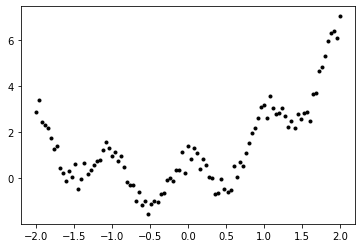

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
import sklearn
# Generate the features
x = torch.linspace(-2,2,101).reshape(-1,1)

# Generate the response variables 
y_obs = x**2 + x + torch.cos(2*np.pi*x) + torch.randn_like(x)*0.3

plt.plot(x,y_obs,'k.')

# Implementing neural networks

Today, we're going to go through the process together of implementing a neural network for a simple regression problem.  Then I'm going to turn you loose to adapt this methodology to the MNIST problem.

We're going to use a new library to implement this network.  This library is called pytorch, and you can easily install it by following the installation instructions found [here](https://pytorch.org/get-started/locally/).  Why are we not using numpy?  We'll return to that in a moment.  However, torch actually behaves significantly like numpy in a variety of ways.  For example we can generate a synthetic dataset (rather similar to that from Homework 2) using some familiar commands:


We'd like to find a function that fits this data.  One way to do this is, of course, linear regression, but that requires specifying the form of the design matrix.  As we saw in lecture, we'd like to learn the design matrix from the data.  We'll use a neural network to perform this task.  Algebraically, we can specify the neural network via the following sequentially applied functions.
$$
\underbrace{z}_{m\times p} = \underbrace{x}_{m\times 1} \underbrace{W^{(1)}}_{1\times p} + \underbrace{b^{(1)}}_{1\times p}
$$
$$
h = \sigma(z)
$$
$$
\underbrace{y}_{m\times 1} = h \underbrace{W^{(2)}}{p \times 1} + \underbrace{b^{(2)}}_{1\times 1}
$$

Because this is getting a bit complicated, let's develop a create a class for this neural network to hold weights and apply functions as appropriate.    

In [2]:
class NeuralNet(object):
    
    def __init__(self,n,p,N):
        self.n = n   # Number of features (1 for univariate problem)
        self.p = p   # Number of nodes in the hidden layer
        self.N = N   # Number of outputs (1 for the regression problem)
        
        # Instantiate weight matrices 
        self.W_1 = torch.randn(n,p)*10
        self.W_2 = torch.randn(p,N)/np.sqrt(p)
        
        # Instantiate bias vectors (Why do we need this?)
        self.b_1 = torch.randn(1,p)*10
        self.b_2 = torch.randn(1,N)/np.sqrt(p)
               
    def forward(self,X):
        # Applies the neural network model
        ## All of these self. prefixes save calculation results
        ## as class variables - we can inspect them later if we
        ## wish to
        self.X = X
        self.z = self.X @ self.W_1 + self.b_1  # First linear 
        self.h = torch.sigmoid(self.z)         # Activation
        self.y = self.h @ self.W_2 + self.b_2  # Second linear
        
        return self.y


You'll notice that we're instantiating weights randomly.  Let's see what type of functions this model produces, prior to training.  It's interesting to see what the effect is of messing with the variance of the weights when initializing them.   

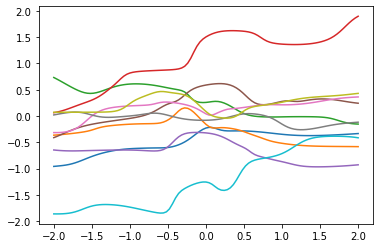

In [3]:
# Sample 10 random neural nets
for i in range(10):
    
    # Create the neural network
    net = NeuralNet(1,20,1)
    
    # Make a prediction
    y_pred = net.forward(x)
    
    # Plot the predictions
    plt.plot(x,y_pred)


Of course, this isn't all that interesting on its own.  We now need to train this thing.  We'll do this using gradient descent, and herein lies the power of pytorch.  It is a framework for *automatic differentiation*.  What does this mean?  It means that it keeps a record of all of the operations that have been done to produce the output of a given function.  It then can *automaticall* apply the chain rule to produce derivatives of a function with respect to anything that was used to compute it.  Here, we're hoping to take the gradient with respect to the weights and biases.  We can tell pytorch that we're going to want these things by using the "requires_grad_" flag.  

In [4]:
class NeuralNet(object):
    
    def __init__(self,n,p,N):
        self.n = n   # Number of features (1 for univariate problem)
        self.p = p   # Number of nodes in the hidden layer
        self.N = N   # Number of outputs (1 for the regression problem)
        
        # Instantiate weight matrices 
        self.W_1 = torch.randn(n,p)*10
        self.W_2 = torch.randn(p,N)/np.sqrt(p)
        
        # Instantiate bias vectors (Why do we need this?)
        self.b_1 = torch.randn(1,p)*10
        self.b_2 = torch.randn(1,N)/np.sqrt(p)
        
        ### CHANGE FROM ABOVE ###  
        # Collect the model parameters, and tell pytorch to
        # collect gradient information about them.
        self.parameters = [self.W_1,self.W_2,self.b_1,self.b_2]
        for param in self.parameters:
            param.requires_grad_()
    def forward(self,X):
        # Applies the neural network model
        ## All of these self. prefixes save calculation results
        ## as class variables - we can inspect them later if we
        ## wish to
        self.X = X
        self.z = self.X @ self.W_1 + self.b_1  # First linear 
        self.h = torch.sigmoid(self.z)         # Activation
        self.y = self.h @ self.W_2 + self.b_2  # Second linear
        return self.y
    
    def zero_grad(self):
        ### Each parameter has an additional array associated
        ### with it to store its gradient.  This is not 
        ### automatically cleared, so we have a method to
        ### clear it.
        for param in self.parameters:
            try:
                param.grad.data[:] = 0.0
            except AttributeError:
                pass
        

One thing that still need is something to minimize.  Since this is a regression problem, we'll use mean-squared-error

In [5]:
def mse(y_pred,y_obs):
    m = y_pred.shape[0]
    return 1./m*((y_pred-y_obs)**2).sum()

Now, the code for gradient descent becomes strikingly simple:

In [6]:
net = NeuralNet(1,20,1)  # Instantiate network
eta = 1e-1               # Set learning rate (empirically derived)
for t in range(50000):   # run for 50000 epochs
    y_pred = net.forward(x)   # Make a prediction
    L = mse(y_pred,y_obs)     # Compute mse
    net.zero_grad()           # Clear gradient buffer
    L.backward()              # MAGIC: compute dL/d parameter
    for param in net.parameters:            # update parameters w/
        param.data -= eta*param.grad.data   # GD
        
    if t%100==0:         # Print loss    
        print(t,L.item())
    
        


0 6.504101276397705
100 0.7401821613311768
200 0.5571304559707642
300 0.43845197558403015
400 0.3615563213825226
500 0.3114233911037445
600 0.27583062648773193
700 0.2487124800682068
800 0.2275533229112625
900 0.21114054322242737
1000 0.19853489100933075
1100 0.18883074820041656
1200 0.18122674524784088
1300 0.1750992238521576
1400 0.17000135779380798
1500 0.1656254231929779
1600 0.16175957024097443
1700 0.1582546830177307
1800 0.15500172972679138
1900 0.1519167125225067
2000 0.14893145859241486
2100 0.14598733186721802
2200 0.14303132891654968
2300 0.14001518487930298
2400 0.13689473271369934
2500 0.13363097608089447
2600 0.13019300997257233
2700 0.12655828893184662
2800 0.12271158397197723
2900 0.11863530427217484
3000 0.1142909973859787
3100 0.10959668457508087
3200 0.1044391393661499
3300 0.09881018847227097
3400 0.09307409822940826
3500 0.08792884647846222
3600 0.08382321149110794
3700 0.08070844411849976
3800 0.0783354640007019
3900 0.0764819085597992
4000 0.07499409466981888
410

31900 0.05474450811743736
32000 0.0547361895442009
32100 0.054727837443351746
32200 0.05471955984830856
32300 0.054711297154426575
32400 0.05470303073525429
32500 0.05469488352537155
32600 0.054686710238456726
32700 0.054678600281476974
32800 0.05467049777507782
32900 0.05466242879629135
33000 0.054654400795698166
33100 0.05464637652039528
33200 0.05463840812444687
33300 0.054630525410175323
33400 0.054622601717710495
33500 0.05461476370692253
33600 0.05460686981678009
33700 0.0545990951359272
33800 0.05459125339984894
33900 0.05458349362015724
34000 0.05457577854394913
34100 0.054568059742450714
34200 0.0545603483915329
34300 0.05455269291996956
34400 0.054545000195503235
34500 0.05453740432858467
34600 0.05452984943985939
34700 0.05452227592468262
34800 0.05451473593711853
34900 0.054507218301296234
35000 0.05449976399540901
35100 0.0544922798871994
35200 0.05448482930660248
35300 0.0544775016605854
35400 0.05447016656398773
35500 0.05446285381913185
35600 0.054455533623695374
35700 

Now we can plot our model prediction versus observations.  Pretty good!  And no manual selection of basis functions.

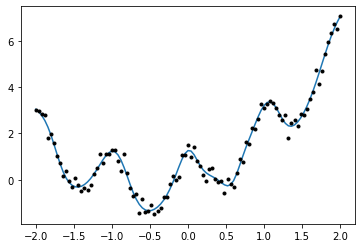

In [7]:
plt.plot(x.detach().squeeze(),y_pred.detach().squeeze())
plt.plot(x.detach().squeeze(),y_obs.detach().squeeze(),'k.')

# Your task:
Train a neural on MNIST using pytorch.  You should use the above code as a template.  Things you'll need to change: $n$ will no longer be 1, but rather 784.  $N$ will no longer be one, but 10.  You'll want to adjust $p$, the number of hidden layer nodes.  You'll likely need to adjust the learning rate.  Finally, and most importantly, you'll need to use a different loss function.  In particular, you'll replace our handrolled MSE code with [this](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).  IMPORTANT NOTE: this loss expects *logits* as inputs, which is to say that it will do softmax for you internally.  As such, the architecture of your network should be more or less the same as above.  

In [3]:
class NeuralNet(object):
    
    def __init__(self,n,p,N):
        self.n = n   # Number of features (1 for univariate problem)
        self.p = p   # Number of nodes in the hidden layer
        self.N = N   # Number of outputs (1 for the regression problem)
        
        # Instantiate weight matrices 
        self.W_1 = torch.randn(n,p)*10
        self.W_2 = torch.randn(p,N)/np.sqrt(p)
        self.W_1 = self.W_1.double()
        self.W_2 = self.W_2.double()
        # Instantiate bias vectors (Why do we need this?)
        self.b_1 = torch.randn(1,p)*10
        self.b_2 = torch.randn(1,N)/np.sqrt(p)
        
        ### CHANGE FROM ABOVE ###  
        # Collect the model parameters, and tell pytorch to
        # collect gradient information about them.
        self.parameters = [self.W_1,self.W_2,self.b_1,self.b_2]
        for param in self.parameters:
            param.requires_grad_()
    def forward(self,X):
        # Applies the neural network model
        ## All of these self. prefixes save calculation results
        ## as class variables - we can inspect them later if we
        ## wish to
        self.X = X
        self.z = self.X @ self.W_1 + self.b_1  # First linear 
        self.h = torch.sigmoid(self.z)         # Activation
        self.y = self.h @ self.W_2 + self.b_2  # Second linear
        return self.y
    
    def zero_grad(self):
        ### Each parameter has an additional array associated
        ### with it to store its gradient.  This is not 
        ### automatically cleared, so we have a method to
        ### clear it.
        for param in self.parameters:
            try:
                param.grad.data[:] = 0.0
            except AttributeError:
                pass
        

In [4]:
data =sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [37]:
mx = torch.tensor(data[0])
my = data[1]
my = torch.tensor(list(map(int, my)))
mx -= mx.mean()
mx/= mx.std()
mnet = NeuralNet(784,25,10)
etl = 1e-1



In [38]:
mx = mx.double()
my_pred = mnet.forward(mx)
test = torch.nn.CrossEntropyLoss()

In [39]:
out = test(my_pred, my)


In [ ]:
for t in range(1000):   # run for 50000 epochs
    my_pred = mnet.forward(mx)   # Make a prediction
    mL = test(my_pred,my)     # Compute mse
    mnet.zero_grad()           # Clear gradient buffer
    mL.backward()              # MAGIC: compute dL/d parameter
    for param in mnet.parameters:            # update parameters w/
        param.data -= etl*param.grad.data   # GD
        
    if t%100==0:         # Print loss    
        print(t,mL.item())

0 2.0940703853763565
100 1.8269277457528623
200 1.6891633674598059
300 1.6089039624512418


In [41]:
A = mnet.W_1.T[0].detach().numpy()
print(np.shape(A))

(784,)


In [47]:
A = mnet.W_1.detach().numpy()
B = mnet.W_2.detach().numpy()
print(np.shape(A), np.shape(B))
weight = A@B

(784, 25) (25, 10)


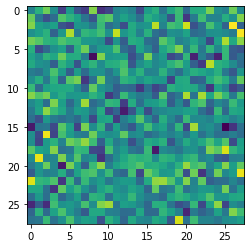

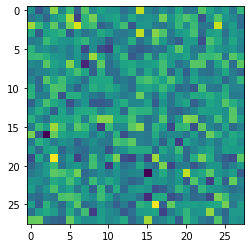

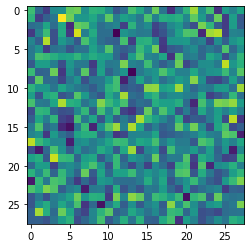

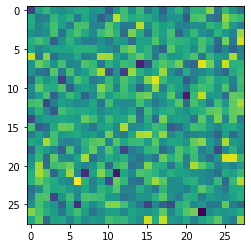

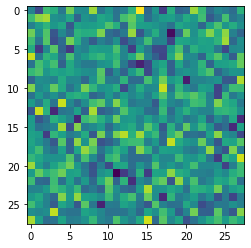

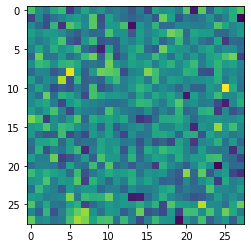

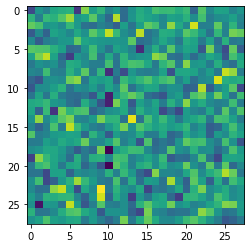

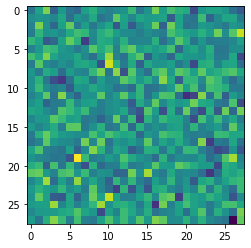

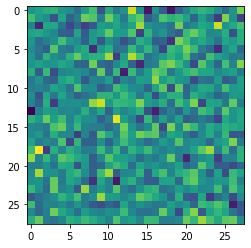

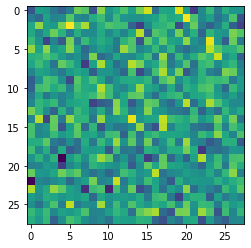

In [48]:

weight_plot = []
for i in range(10):
    weight_plot.append(weight.T[i])
for i in range(len(weight_plot)):
    plt.imshow(np.reshape(weight_plot[i],(28,28)))
    plt.show()